In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset

import numpy as np
from IPython.display import clear_output

In [2]:
from cosmoNODE.loaders import LC
from cosmoNODE import utils

/home/sippycups/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sippycups/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sippycups/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sippycups/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [8]:
lc = LC(cols=['mjd', 'flux', 'passband'], groupby_cols=['object_id'])

In [9]:
curve = lc[0]

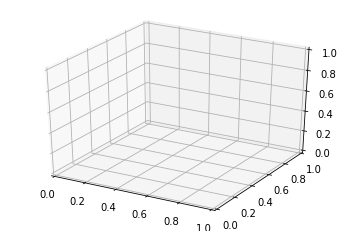

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

In [18]:
t = curve['mjd']
y = curve['flux']
z = curve['passband']

In [19]:
ax.plot(t, y, z, c='r')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.09379629152477453, 0.012566320283548621, 'Z Label')

In [20]:
plt.show()

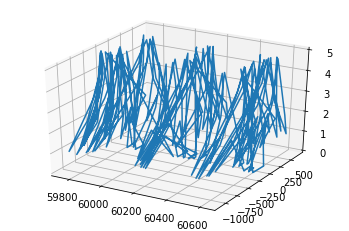

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(t, y, z)


In [31]:
ys = curve[['flux', 'passband']].values
ts = torch.tensor(t)
dim = ys.shape[-1]
ys_reshaped = torch.tensor(ys).reshape(-1, 1, dim)
y0 = ys_reshaped[0]
print(y0)

tensor([[-544.8103,    2.0000]], dtype=torch.float64)


In [37]:
train_size = len(ts)
print(train_size)
batch_time = 10
batch_size = 20

352


In [36]:
def ode_batch(time_sols, flux_sols):
    s = torch.from_numpy(np.random.choice(np.arange(train_size - batch_time, dtype=np.int64), batch_size, replace=True))
#     print(s)
    batch_y0 = flux_sols[s]  # (M, D)
    batch_t = time_sols[:batch_time]  # (T)
    batch_y = torch.stack([flux_sols[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [38]:
by0_f, bt_f, by_f = ode_batch(ts, ys_reshaped)
print(f'by0.shape : {by0_f.shape}, bt.shape: {bt_f.shape}, by.shape: {by_f.shape}')

by0.shape : torch.Size([20, 1, 2]), bt.shape: torch.Size([10]), by.shape: torch.Size([10, 20, 1, 2])


In [39]:
adjoint = True

if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [40]:
class ODEFunc(nn.Module):

    def __init__(self, dim):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(dim, 50),
            nn.Tanh(),
            nn.Linear(50, dim),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)


In [41]:
func = ODEFunc(dim)

In [ ]:
pred = odeint(func, by0_f, bt_f, rtol=r_tol, atol=a_tol)